# Detección de señales en FAERS a nivel reporte con análisis por rol del fármaco


## 1. Justificación del estudio

La farmacovigilancia busca identificar de manera temprana posibles asociaciones entre medicamentos y eventos adversos a partir de grandes bases de datos de reportes espontáneos. En este contexto, la base **FAERS** constituye una fuente clave para el análisis exploratorio de señales de seguridad, debido a su volumen, cobertura internacional y actualización periódica.

En este estudio se propone un pipeline reproducible para la **detección de señales de desproporcionalidad** usando datos procesados por trimestre (2025), integrando información de:

- **fármacos** (`drugs`),
- **reacciones** (`reactions`),
- **metadatos del reporte** (`reports`).

A partir de estas tablas se construyen pares **(fármaco, reacción)** asociados al mismo `safetyreportid`, y se calculan métricas clásicas de farmacovigilancia como:

- **ROR** (*Reporting Odds Ratio*),
- **PRR** (*Proportional Reporting Ratio*),
- **intervalos de confianza al 95%**.

### 1.1. ¿Por qué este estudio es útil?

Este análisis permite:

- identificar pares medicamento–evento con **desproporcionalidad elevada**;
- priorizar asociaciones que requieren revisión clínica posterior;
- comparar resultados según el **rol del fármaco** (por ejemplo, **PS** = *Primary Suspect*);
- separar señales clínicas de términos más administrativos/operacionales (por ejemplo, *MEDICATION ERROR*, *DEVICE ISSUE*, *OFF LABEL USE*), mejorando la interpretabilidad.

### 1.2. Alcance metodológico actual 

En esta versión del pipeline, los archivos disponibles por trimestre contienen:

- `drugs`: información de medicamento y rol (`drugcharacterization`);
- `reactions`: términos MedDRA PT (`reaction_pt`);
- `reports`: metadatos del reporte (`occurcountry`, `receiptdate`).

Sin embargo, **no se dispone de `caseid` ni `version`** (o `caseversion`), por lo que:

- el análisis se realiza **a nivel reporte** (`safetyreportid`),
- **no** se aplica aún la deduplicación canónica de FAERS por **caso + versión**.

Esto no invalida el análisis exploratorio; simplemente define su alcance actual. En una fase posterior, al incorporar una tabla DEMO con `caseid` y `caseversion`, el mismo pipeline podrá extenderse a un análisis canónico a nivel caso.

### 1.3. Estrategia analítica

Se emplean tres esquemas (PS, PS+SS y ALL) para hacer un análisis de señales más robusto e interpretable, evaluando cómo cambia el resultado según el rol atribuido al fármaco en el reporte.

- **PS (Primary Suspect)** se usa como análisis principal porque prioriza los pares donde el medicamento fue señalado como sospechoso principal, lo que suele dar una interpretación clínica más directa.

- **PS+SS (Primary + Secondary Suspect)** funciona como análisis de sensibilidad, porque amplía la cobertura a medicamentos también considerados sospechosos, aunque no principales, y permite ver si las señales se mantienen.

- **ALL (todos los roles)** ofrece una visión amplia del sistema de reportes, incluyendo concomitantes e interactuantes, útil para comparar el efecto de incluir toda la información disponible.

En conjunto, estos tres esquemas permiten responder preguntas como:

¿La señal depende de restringirnos a PS?

¿Se mantiene al incluir SS?

¿Cambia mucho al incorporar todos los roles?

Esto mejora la transparencia metodológica y fortalece la interpretación de los resultados.

Además, se propone etiquetar ciertos términos de reacción como **administrativos/operacionales** (`admin-like`) para generar dos vistas complementarias:

- **análisis clínico principal** (excluye admin-like),
- **análisis operativo/complementario** (incluye o aísla admin-like).

Esta separación es útil para evitar que términos no clínicos dominen los rankings principales de señales, sin perder información relevante para farmacovigilancia de uso, calidad y errores de medicación.


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import re

Carga de archivos por trimestre y construcción de pares (drugs + reactions + reports)**

**Objetivo:**  
Leer los tres archivos por trimestre (`drugs`, `reactions`, `reports`), normalizar columnas, construir una clave de fármaco (`drug_key`) y generar los pares `(drug_key, reaction_pt)` por `safetyreportid`.

**Qué hace:**
1. Recorre las carpetas trimestrales (Q1–Q4).
2. Lee archivos `.csv` de forma robusta (`utf-8-sig`) para evitar problemas con BOM.
3. Normaliza nombres de columnas (minúsculas, sin espacios extra).
4. Verifica columnas mínimas requeridas:
   - `drugs`: `safetyreportid`, `drug_key` (o columnas para construirlo),
   - `reactions`: `safetyreportid`, `reaction_pt`,
   - `reports`: `safetyreportid`.
5. Si `drug_key` no existe, lo construye desde:
   - `activesubstancename` (preferido), o
   - `medicinalproduct` (alternativa).
6. Limpia texto de `drug_key` y `reaction_pt`.
7. Une `drugs × reactions` por `safetyreportid` para generar pares.
8. Enriquece con `reports` (`occurcountry`, `receiptdate`).
9. Concatena todos los trimestres en un solo `DataFrame` (`pairs`).


In [2]:
BASE_ROOT = Path("data_processed")
quarters = ["q1_2025_sample100k", "q2_2025_sample100k", "q3_2025_sample100k", "q4_2025_sample100k"]

def find_one_csv(qdir: Path, pattern_list):
    for pat in pattern_list:
        hits = list(qdir.glob(pat))
        if hits:
            return hits[0]
    return None

def read_csv_robust(fp: Path):
    # utf-8-sig elimina BOM si existe
    return pd.read_csv(fp, low_memory=False, encoding="utf-8-sig")

def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (
        pd.Index(df.columns)
        .map(lambda c: str(c).replace("\ufeff", "").strip().lower())
    )
    return df

def clean_text_key(s: pd.Series) -> pd.Series:
    # normalización ligera para llaves de texto
    s = s.astype(str).str.upper().str.strip()
    s = s.str.replace(r"\s+", " ", regex=True)
    s = s.str.replace(r"[^A-Z0-9 /+\-().,]", "", regex=True)
    s = s.replace({"NAN": np.nan, "NONE": np.nan, "": np.nan})
    return s

all_pairs = []
all_reports = []

for q in quarters:
    qdir = BASE_ROOT / q
    
    fp_drugs = find_one_csv(qdir, ["*drugs*.csv"])
    fp_reac  = find_one_csv(qdir, ["*reactions*.csv"])
    fp_rep   = find_one_csv(qdir, ["*reports*.csv"])
    
    if not (fp_drugs and fp_reac and fp_rep):
        print(f"[WARN] Faltan archivos en {qdir}")
        print("drugs:", fp_drugs)
        print("reactions:", fp_reac)
        print("reports:", fp_rep)
        continue
    
    print(f"\n=== {q} ===")
    print("drugs     :", fp_drugs.name)
    print("reactions :", fp_reac.name)
    print("reports   :", fp_rep.name)

    # Carga CSV
    d = read_csv_robust(fp_drugs)
    r = read_csv_robust(fp_reac)
    rep = read_csv_robust(fp_rep)

    # Normalizar nombres de columnas
    d = normalize_columns(d)
    r = normalize_columns(r)
    rep = normalize_columns(rep)

    # DEBUG útil: ver columnas reales
    print("drugs cols:", list(d.columns))
    print("reac  cols:", list(r.columns))
    print("rep   cols:", list(rep.columns))

    # Validar columnas mínimas
    if "safetyreportid" not in d.columns:
        raise ValueError(f"{q}: drugs no tiene 'safetyreportid'")
    if "safetyreportid" not in r.columns:
        raise ValueError(f"{q}: reactions no tiene 'safetyreportid'")
    if "reaction_pt" not in r.columns:
        raise ValueError(f"{q}: reactions no tiene 'reaction_pt'")
    if "safetyreportid" not in rep.columns:
        raise ValueError(f"{q}: reports no tiene 'safetyreportid'")

    # Crear drug_key si no existe
    if "drug_key" not in d.columns:
        print(f"[INFO] {q}: 'drug_key' no existe; se construirá.")
        
        if "activesubstancename" in d.columns:
            d["drug_key"] = clean_text_key(d["activesubstancename"])
            source_used = "activesubstancename"
        elif "medicinalproduct" in d.columns:
            d["drug_key"] = clean_text_key(d["medicinalproduct"])
            source_used = "medicinalproduct"
        else:
            raise ValueError(
                f"{q}: drugs no tiene 'drug_key' ni columnas para construirlo "
                f"(activesubstancename/medicinalproduct)."
            )
        print(f"[INFO] {q}: drug_key construido desde '{source_used}'")
    else:
        d["drug_key"] = clean_text_key(d["drug_key"])

    # Limpieza reaction_pt
    r["reaction_pt"] = clean_text_key(r["reaction_pt"])

    # Mantener columnas útiles
    keep_d = ["safetyreportid", "drug_key"]
    for c in ["drugcharacterization", "medicinalproduct", "activesubstancename"]:
        if c in d.columns:
            keep_d.append(c)
    d = d[keep_d].copy()

    keep_r = ["safetyreportid", "reaction_pt"]
    if "reaction_meddra_version_pt" in r.columns:
        keep_r.append("reaction_meddra_version_pt")
    r = r[keep_r].copy()

    keep_rep = ["safetyreportid"]
    for c in ["occurcountry", "receiptdate"]:
        if c in rep.columns:
            keep_rep.append(c)
    rep = rep[keep_rep].copy()

    # Tipos
    for x in [d, r, rep]:
        x["safetyreportid"] = pd.to_numeric(x["safetyreportid"], errors="coerce")
        x.dropna(subset=["safetyreportid"], inplace=True)

    if "drugcharacterization" in d.columns:
        d["drugcharacterization"] = pd.to_numeric(d["drugcharacterization"], errors="coerce")

    # Quitar vacíos en llaves
    d = d.dropna(subset=["drug_key"])
    r = r.dropna(subset=["reaction_pt"])

    # Deduplicar bases antes del merge (reduce explosión artificial)
    d = d.drop_duplicates()
    r = r.drop_duplicates()
    rep = rep.drop_duplicates(subset=["safetyreportid"])

    # Merge drugs x reactions por safetyreportid (genera pares)
    pairs_q = d.merge(r, on="safetyreportid", how="inner", validate="m:m")
    pairs_q["quarter"] = q

    # Enriquecer con reports (metadatos)
    pairs_q = pairs_q.merge(rep, on="safetyreportid", how="left", validate="m:1")

    all_pairs.append(pairs_q)
    all_reports.append(rep.assign(quarter=q))

    print("pairs_q shape:", pairs_q.shape)
    print("reports_q shape:", rep.shape)
    print("drug_key nulos:", pairs_q["drug_key"].isna().sum(), "| reaction_pt nulos:", pairs_q["reaction_pt"].isna().sum())

if not all_pairs:
    raise ValueError("No se pudo construir ningún trimestre. Revisa rutas/archivos.")

pairs = pd.concat(all_pairs, ignore_index=True)
reports_all = pd.concat(all_reports, ignore_index=True)

print("\n=== TOTAL ===")
print("pairs shape:", pairs.shape)
print("columns:", list(pairs.columns))
print("quarters:\n", pairs["quarter"].value_counts(dropna=False))
pairs.head()


=== q1_2025_sample100k ===
drugs     : q1_drugs_100k.csv
reactions : q1_reactions_100k.csv
reports   : q1_reports_100k.csv
drugs cols: ['safetyreportid', 'medicinalproduct', 'drugcharacterization', 'activesubstancename']
reac  cols: ['safetyreportid', 'reaction_pt', 'reaction_meddra_version_pt']
rep   cols: ['safetyreportid', 'occurcountry', 'receiptdate']
[INFO] q1_2025_sample100k: 'drug_key' no existe; se construirá.
[INFO] q1_2025_sample100k: drug_key construido desde 'activesubstancename'
pairs_q shape: (2994020, 10)
reports_q shape: (100000, 3)
drug_key nulos: 0 | reaction_pt nulos: 0

=== q2_2025_sample100k ===
drugs     : q2_drugs_100k.csv
reactions : q2_reactions_100k.csv
reports   : q2_reports_100k.csv
drugs cols: ['safetyreportid', 'medicinalproduct', 'drugcharacterization', 'activesubstancename']
reac  cols: ['safetyreportid', 'reaction_pt', 'reaction_meddra_version_pt']
rep   cols: ['safetyreportid', 'occurcountry', 'receiptdate']
[INFO] q2_2025_sample100k: 'drug_key' no e

,safetyreportid,drug_key,drugcharacterization,medicinalproduct,activesubstancename,reaction_pt,reaction_meddra_version_pt,quarter,occurcountry,receiptdate
0,24795582,BUDESONIDEFORMOTEROL FUMARATE DIHYDRATE,1.0,SYMBICORT,BUDESONIDE\FORMOTEROL FUMARATE DIHYDRATE,ASTHMA,27.1,q1_2025_sample100k,US,20250101
1,24795583,DUPILUMAB,1.0,DUPIXENT,DUPILUMAB,NASAL POLYPS,27.1,q1_2025_sample100k,US,20250101
2,24795583,DUPILUMAB,1.0,DUPIXENT,DUPILUMAB,CONDITION AGGRAVATED,27.1,q1_2025_sample100k,US,20250101
3,24795583,DUPILUMAB,1.0,DUPIXENT,DUPILUMAB,INAPPROPRIATE SCHEDULE OF PRODUCT ADMINISTRATION,27.1,q1_2025_sample100k,US,20250101
4,24795584,ROSUVASTATIN CALCIUM,1.0,CRESTOR,ROSUVASTATIN CALCIUM,DRUG INTERACTION,27.1,q1_2025_sample100k,US,20250101




Se cargaron correctamente los archivos `drugs`, `reactions` y `reports` de los cuatro trimestres de 2025, verificando que las columnas necesarias estuvieran presentes. Como `drug_key` no venía en los archivos de `drugs`, se construyó automáticamente a partir de `activesubstancename` en todos los trimestres.

Después de unir medicamentos y reacciones por `safetyreportid` (y enriquecer con metadatos de `reports`), se generaron los pares medicamento–reacción por trimestre (`pairs_q`) y luego se concatenaron en una sola base `pairs` con **11,570,960 filas** y **10 columnas**. Además, se verificó que no hubiera valores nulos en las variables clave (`drug_key` y `reaction_pt`), lo que confirma que la base quedó lista para el análisis de señales a nivel reporte.

### Mapeo de `drugcharacterization` a roles (PS/SS/C/I/O)

**Objetivo:**  
Traducir los códigos numéricos de FAERS en una etiqueta de rol interpretable (`role_cod`).

**Qué hace:**
- Convierte `drugcharacterization` a numérico.
- Aplica un mapeo típico:
  - `1 → PS` (Primary Suspect),
  - `2 → SS` (Secondary Suspect),
  - `3 → C` (Concomitant),
  - `4 → I` (Interacting),
  - `5 → O` (otros/ocasional).
- Crea la columna `role_cod`.

**Por qué es importante:**
Permite definir el análisis principal en términos clínicamente más plausibles (por ejemplo, `PS`) y hacer análisis de sensibilidad con otras combinaciones.


In [3]:
# Mapeo FAERS típico de drugcharacterization
# 1=PS, 2=SS, 3=C, 4=I, 5=O (ocasional)
role_map = {
    1: "PS",
    2: "SS",
    3: "C",
    4: "I",
    5: "O"
}

pairs["drugcharacterization"] = pd.to_numeric(pairs["drugcharacterization"], errors="coerce")
pairs["role_cod"] = pairs["drugcharacterization"].map(role_map).fillna("UNK")

print("Distribución de roles:")
print(pairs["role_cod"].value_counts(dropna=False).rename_axis("role_cod").reset_index(name="n"))

print("\nDistribución de drugcharacterization cruda:")
pairs["drugcharacterization"].value_counts(dropna=False).sort_index()

Distribución de roles:
  role_cod        n
0       PS  6388933
1       SS  5128646
2        C    53255
3        I      121
4      UNK        5

Distribución de drugcharacterization cruda:


drugcharacterization
1.0    6388933
2.0    5128646
3.0      53255
4.0        121
NaN          5
Name: count, dtype: int64

Se mapeó correctamente la variable `drugcharacterization` a etiquetas de rol (`role_cod`) y mostró que la gran mayoría de los registros corresponden a fármacos sospechosos:

- **PS (Primary Suspect):** 6,388,933
- **SS (Secondary Suspect):** 5,128,646

En mucho menor proporción aparecen:

- **C (Concomitant):** 53,255
- **I (Interacting):** 121
- **UNK:** 5 (valores faltantes/no mapeados)

La distribución cruda de `drugcharacterization` confirma exactamente este patrón (1→PS, 2→SS, 3→C, 4→I), con solo **5 valores faltantes (`NaN`)**. Esto indica que el mapeo de roles quedó bien definido y que el análisis por esquemas (PS, PS+SS, ALL) puede realizarse con buena consistencia.

### Auditoría descriptiva del dataset de pares

**Objetivo:**  
Resumir el dataset construido antes de calcular señales.

**Qué hace:**
- Reporta:
  - número total de filas,
  - reportes únicos (`safetyreportid`),
  - fármacos únicos (`drug_key`),
  - reacciones únicas (`reaction_pt`),
  - número de trimestres.
- Muestra distribuciones rápidas (por ejemplo, top países, top fármacos, top reacciones).
- Documenta explícitamente la limitación metodológica actual:
  - el análisis está a nivel `safetyreportid`,
  - no hay deduplicación por `caseid + version`.

**Por qué es importante:**
Esta celda sirve como control de calidad y como evidencia metodológica para tesis.


In [4]:
print("=== Auditoría de pairs ===")
print("Filas totales:", len(pairs))
print("Reportes únicos:", pairs["safetyreportid"].nunique())
print("Drugs únicos (drug_key):", pairs["drug_key"].nunique())
print("Reacciones únicas (PT):", pairs["reaction_pt"].nunique())
print("Trimestres:", pairs["quarter"].nunique())

print("\nTop 10 países (occurcountry):")
display(pairs["occurcountry"].astype(str).value_counts(dropna=False).head(10))

print("\nTop 10 drug_key:")
display(pairs["drug_key"].value_counts().head(10))

print("\nTop 10 reaction_pt:")
display(pairs["reaction_pt"].value_counts().head(10))

# Confirmar limitación metodológica actual
print("\n[INFO] Nivel de análisis actual: safetyreportid (reporte)")
print("[INFO] No hay caseid/version en estos archivos; no aplica deduplicación canónica FAERS por caso todavía.")

=== Auditoría de pairs ===
Filas totales: 11570960
Reportes únicos: 390140
Drugs únicos (drug_key): 6711
Reacciones únicas (PT): 13098
Trimestres: 4

Top 10 países (occurcountry):


occurcountry
CA     6144121
US     3294210
EU      466857
nan     281368
GB      258296
JP      185573
DE      133609
CN       97834
FR       93948
AU       60113
Name: count, dtype: int64


Top 10 drug_key:


drug_key
ACETAMINOPHEN               186848
PREDNISONE                  140187
CHOLECALCIFEROL             118188
ADALIMUMAB                  114430
DUPILUMAB                   104318
CETIRIZINE HYDROCHLORIDE    103104
INFLIXIMAB                   97467
LEFLUNOMIDE                  96952
RITUXIMAB                    91162
METHOTREXATE                 88926
Name: count, dtype: int64


Top 10 reaction_pt:


reaction_pt
OFF LABEL USE       168454
FATIGUE             134550
DRUG INEFFECTIVE    129021
NAUSEA              116422
HEADACHE            110655
PAIN                105876
DIARRHOEA           102874
DYSPNOEA             95181
VOMITING             85925
ARTHRALGIA           80241
Name: count, dtype: int64


[INFO] Nivel de análisis actual: safetyreportid (reporte)
[INFO] No hay caseid/version en estos archivos; no aplica deduplicación canónica FAERS por caso todavía.


La auditoría de pairs muestra que la base consolidada contiene 11,570,960 filas correspondientes a 390,140 reportes únicos (safetyreportid), con 6,711 fármacos (drug_key) y 13,098 reacciones PT distribuidos en 4 trimestres. En occurcountry, predominan los reportes con código CA y US, seguidos por EU, además de una fracción de valores faltantes. Entre los fármacos más frecuentes destacan ACETAMINOPHEN, PREDNISONE, CHOLECALCIFEROL, ADALIMUMAB y DUPILUMAB, mientras que entre las reacciones más reportadas aparecen tanto términos clínicos (por ejemplo, FATIGUE, NAUSEA, HEADACHE) como términos administrativos/operacionales (por ejemplo, OFF LABEL USE, DRUG INEFFECTIVE), lo cual justifica posteriormente separar PTs admin-like del análisis clínico principal. Finalmente, la auditoría confirma explícitamente que el nivel de análisis actual es por reporte (safetyreportid), ya que estos archivos no incluyen caseid/version, por lo que aún no se aplica la deduplicación canónica de FAERS por caso.

### Definición de subconjuntos por rol y esquema principal

**Objetivo:**  
Construir subconjuntos para comparar señales según el rol del fármaco.

**Qué hace:**
- Estandariza `drug_key` y `reaction_pt`.
- Crea:
  - `pairs_ps` (solo `PS`),
  - `pairs_ps_ss` (`PS` + `SS`),
  - `pairs_allroles` (todos los roles).
- Define:
  - `pairs_main` como el conjunto principal (idealmente `PS`),
  - `MAIN_SCHEME` para registrar qué esquema se usó.

**Por qué es importante:**
En farmacovigilancia, el rol del fármaco afecta la interpretación. `PS` suele ser el análisis principal más interpretativo.


In [5]:
# Estandarización final de texto 
pairs["drug_key"] = pairs["drug_key"].astype(str).str.strip().str.upper()
pairs["reaction_pt"] = pairs["reaction_pt"].astype(str).str.strip().str.upper()

# Subconjuntos por rol
pairs_ps = pairs[pairs["role_cod"].eq("PS")].copy()
pairs_ps_ss = pairs[pairs["role_cod"].isin(["PS", "SS"])].copy()
pairs_allroles = pairs.copy()

print("=== Tamaños por esquema ===")
print("PS    :", len(pairs_ps))
print("PS+SS :", len(pairs_ps_ss))
print("ALL   :", len(pairs_allroles))

print("\nReportes únicos por esquema:")
print("PS    :", pairs_ps["safetyreportid"].nunique())
print("PS+SS :", pairs_ps_ss["safetyreportid"].nunique())
print("ALL   :", pairs_allroles["safetyreportid"].nunique())

# Principal
pairs_main = pairs_ps if len(pairs_ps) > 0 else pairs_allroles
MAIN_SCHEME = "PS" if len(pairs_ps) > 0 else "ALL"
print("\nAnálisis principal:", MAIN_SCHEME)

=== Tamaños por esquema ===
PS    : 6388933
PS+SS : 11517579
ALL   : 11570960

Reportes únicos por esquema:
PS    : 388573
PS+SS : 389231
ALL   : 390140

Análisis principal: PS


La salida de la celda 4 muestra la partición del dataset según el rol del fármaco (`role_cod`) para definir el esquema de análisis. El subconjunto **PS** (Primary Suspect) contiene **6,388,933 filas**, mientras que **PS+SS** (Primary + Secondary Suspect) concentra **11,517,579 filas**, muy cercano al total **ALL** de **11,570,960 filas**. En términos de cobertura por reportes únicos (`safetyreportid`), **PS** incluye **388,573** reportes, **PS+SS** incluye **389,231**, y **ALL** alcanza **390,140** reportes. Esto indica que el esquema **PS** conserva la gran mayoría de los reportes del conjunto total, pero restringe los pares a aquellos donde el fármaco fue marcado como sospechoso principal, lo que mejora la interpretabilidad clínica. Por esta razón, el pipeline fija **PS como análisis principal**, dejando **PS+SS** y **ALL** como análisis de sensibilidad.

###  Función para construir la tabla de señales (conteos 2×2, ROR, PRR, IC95%)

**Objetivo:**  
Implementar una función reutilizable para calcular señales de desproporcionalidad a nivel reporte.

**Qué hace la función `build_signal_table_report_level(...)`:**
1. Elimina nulos en columnas clave.
2. Deduplica internamente por reporte para evitar sobreconteo:
   - `(reporte, fármaco, reacción)` para `n11`,
   - `(reporte, fármaco)` para `n1.`,
   - `(reporte, reacción)` para `n.1`.
3. Calcula el universo `N` (reportes únicos).
4. Construye los conteos de la tabla 2×2:
   - `n11`, `n10`, `n01`, `n00`.
5. Calcula:
   - **ROR**,
   - **IC95% del ROR** (sobre log-ROR),
   - **PRR**.
6. Aplica corrección de **Haldane-Anscombe** (`+0.5`) cuando hay celdas con cero.
7. Marca señales con criterios simples:
   - `signal_ror`: `n11 >= 5` y `ROR_L95 > 1`,
   - `signal_prr`: `n11 >= 5` y `PRR >= 2`,
   - `signal_both`: ambas condiciones.
8. Crea un `priority_score` para priorización exploratoria.

**Por qué es importante:**
Centraliza la lógica del cálculo y permite reutilizarla para `PS`, `PS+SS` y `ALL`.


In [6]:
MIN_N11 = 5
HALDANE_EPS = 0.5

def build_signal_table_report_level(df_pairs: pd.DataFrame,
                                    unit_id: str = "safetyreportid",
                                    drug_col: str = "drug_key",
                                    reac_col: str = "reaction_pt",
                                    min_n11: int = 5,
                                    eps: float = 0.5) -> pd.DataFrame:
    """
    Construye tabla de señales (D,A) a nivel reporte (safetyreportid),
    con conteos 2x2, ROR, PRR e IC95%.
    """
    df = df_pairs.copy()
    df = df.dropna(subset=[unit_id, drug_col, reac_col]).copy()

    # Deduplicación por unidad (reporte)
    df4 = df.drop_duplicates([unit_id, drug_col, reac_col])  # (D,A) por reporte
    dfD = df.drop_duplicates([unit_id, drug_col])            # D por reporte
    dfA = df.drop_duplicates([unit_id, reac_col])            # A por reporte

    N = df[unit_id].nunique()

    # Conteos
    n11 = (df4.groupby([drug_col, reac_col]).size().rename("n11").reset_index())
    n1dot = (dfD.groupby(drug_col).size().rename("n1dot").reset_index())
    ndot1 = (dfA.groupby(reac_col).size().rename("ndot1").reset_index())

    sig = (n11.merge(n1dot, on=drug_col, how="left")
              .merge(ndot1, on=reac_col, how="left"))

    sig["N"] = float(N)
    sig["n10"] = sig["n1dot"] - sig["n11"]
    sig["n01"] = sig["ndot1"] - sig["n11"]
    sig["n00"] = sig["N"] - (sig["n11"] + sig["n10"] + sig["n01"])

    for c in ["n11","n10","n01","n00","n1dot","ndot1","N"]:
        sig[c] = pd.to_numeric(sig[c], errors="coerce").astype(float)

    # Filtrar filas inválidas
    sig = sig[(sig[["n11","n10","n01","n00"]] >= 0).all(axis=1)].copy()

    a = sig["n11"].to_numpy()
    b = sig["n10"].to_numpy()
    c = sig["n01"].to_numpy()
    d = sig["n00"].to_numpy()

    # Corrección de Haldane-Anscombe solo cuando haya ceros
    a2 = np.where(a == 0, a + eps, a)
    b2 = np.where(b == 0, b + eps, b)
    c2 = np.where(c == 0, c + eps, c)
    d2 = np.where(d == 0, d + eps, d)

    # ROR + IC95%
    sig["ROR"] = (a2 * d2) / (b2 * c2)
    sig["logROR"] = np.log(sig["ROR"])
    sig["SE_logROR"] = np.sqrt(1/a2 + 1/b2 + 1/c2 + 1/d2)
    sig["ROR_L95"] = np.exp(sig["logROR"] - 1.96 * sig["SE_logROR"])
    sig["ROR_U95"] = np.exp(sig["logROR"] + 1.96 * sig["SE_logROR"])

    # PRR
    sig["PRR"] = (a2 / (a2 + b2)) / (c2 / (c2 + d2))

    # Señales
    sig["signal_ror"] = (sig["n11"] >= min_n11) & (sig["ROR_L95"] > 1)
    sig["signal_prr"] = (sig["n11"] >= min_n11) & (sig["PRR"] >= 2)
    sig["signal_both"] = sig["signal_ror"] & sig["signal_prr"]

    # Ranking exploratorio
    sig["priority_score"] = np.log(np.clip(sig["ROR_L95"], 1e-12, None)) * np.log1p(sig["n11"])

    sig["unit_id_used"] = unit_id
    return sig.sort_values(["signal_ror", "ROR_L95", "n11"], ascending=[False, False, False]).reset_index(drop=True)

###  Ejecución del cálculo de señales para PS / PS+SS / ALL

**Objetivo:**  
Aplicar la función de señales a cada esquema y comparar resultados globales.

**Qué hace:**
- Ejecuta la función sobre:
  - `pairs_ps`,
  - `pairs_ps_ss`,
  - `pairs_allroles`.
- Genera:
  - `sig_ps`,
  - `sig_ps_ss`,
  - `sig_all`.
- Construye `summary_signals` con un resumen comparativo:
  - número de reportes,
  - pares totales evaluados,
  - número de señales según ROR, PRR, y ambos criterios.

**Por qué es importante:**
Permite evaluar la sensibilidad del resultado a la elección del rol del fármaco.


In [7]:
# Construcción de señales para tres esquemas
sig_ps = build_signal_table_report_level(pairs_ps, min_n11=MIN_N11, eps=HALDANE_EPS) if len(pairs_ps) else pd.DataFrame()
sig_ps_ss = build_signal_table_report_level(pairs_ps_ss, min_n11=MIN_N11, eps=HALDANE_EPS) if len(pairs_ps_ss) else pd.DataFrame()
sig_all = build_signal_table_report_level(pairs_allroles, min_n11=MIN_N11, eps=HALDANE_EPS)

summary_signals = pd.DataFrame([
    {
        "scheme": "PS",
        "N_reports": int(pairs_ps["safetyreportid"].nunique()) if len(pairs_ps) else 0,
        "pairs_total": int(len(sig_ps)) if len(sig_ps) else 0,
        "signal_ror_count": int(sig_ps["signal_ror"].sum()) if len(sig_ps) else 0,
        "signal_prr_count": int(sig_ps["signal_prr"].sum()) if len(sig_ps) else 0,
        "signal_both_count": int(sig_ps["signal_both"].sum()) if len(sig_ps) else 0,
    },
    {
        "scheme": "PS+SS",
        "N_reports": int(pairs_ps_ss["safetyreportid"].nunique()) if len(pairs_ps_ss) else 0,
        "pairs_total": int(len(sig_ps_ss)) if len(sig_ps_ss) else 0,
        "signal_ror_count": int(sig_ps_ss["signal_ror"].sum()) if len(sig_ps_ss) else 0,
        "signal_prr_count": int(sig_ps_ss["signal_prr"].sum()) if len(sig_ps_ss) else 0,
        "signal_both_count": int(sig_ps_ss["signal_both"].sum()) if len(sig_ps_ss) else 0,
    },
    {
        "scheme": "ALL",
        "N_reports": int(pairs_allroles["safetyreportid"].nunique()),
        "pairs_total": int(len(sig_all)),
        "signal_ror_count": int(sig_all["signal_ror"].sum()),
        "signal_prr_count": int(sig_all["signal_prr"].sum()),
        "signal_both_count": int(sig_all["signal_both"].sum()),
    }
])

print("=== Resumen de señales ===")
summary_signals

=== Resumen de señales ===


,scheme,N_reports,pairs_total,signal_ror_count,signal_prr_count,signal_both_count
0,PS,388573,702315,139587,138130,137038
1,PS+SS,389231,1443394,229457,223059,219197
2,ALL,390140,1448221,230929,224473,220610


El resumen de señales muestra el efecto del esquema de rol del fármaco sobre el número de pares evaluados y las señales detectadas. En el análisis principal PS, se analizaron 388,573 reportes y se obtuvieron 702,315 pares medicamento–reacción únicos, con 139,587 señales por ROR, 138,130 por PRR y 137,038 que cumplen ambos criterios. Al ampliar a PS+SS, el número de reportes aumenta ligeramente a 389,231, pero los pares casi se duplican (1,443,394), lo que incrementa las señales detectadas (229,457 por ROR, 223,059 por PRR, 219,197 por ambos). El esquema ALL incluye 390,140 reportes y 1,448,221 pares, con resultados muy cercanos a PS+SS (230,929, 224,473 y 220,610, respectivamente), lo que sugiere que la mayor diferencia respecto a PS proviene de incorporar los fármacos SS, mientras que los roles concomitantes/interactuantes aportan relativamente poco. En conjunto, estos resultados respaldan usar PS como análisis principal por interpretabilidad, y PS+SS/ALL como análisis de sensibilidad.

###  Top señales del análisis principal

**Objetivo:**  
Inspeccionar manualmente las señales más relevantes del análisis principal (`PS`, o `ALL` si no hay `PS`).

**Qué hace:**
- Define `sig_main` (usualmente `sig_ps`).
- Genera rankings:
  - por `ROR_L95` (más conservador en términos de incertidumbre),
  - por `priority_score` (balance exploratorio entre fuerza de señal y frecuencia).
- Muestra columnas clave:
  - `drug_key`, `reaction_pt`, `n11`, `ROR`, `ROR_L95`, `PRR`, etc.

**Por qué es importante:**
Facilita una primera revisión clínica/epidemiológica de las señales detectadas.


In [8]:
sig_main = sig_ps if len(sig_ps) else sig_all

top_ror = (sig_main[sig_main["signal_ror"]]
           .sort_values(["ROR_L95", "n11"], ascending=[False, False])
           [["drug_key","reaction_pt","n11","ROR","ROR_L95","ROR_U95","PRR","priority_score"]]
           .head(30))

top_score = (sig_main[sig_main["signal_ror"]]
             .sort_values(["priority_score", "n11"], ascending=[False, False])
             [["drug_key","reaction_pt","n11","ROR","ROR_L95","PRR","priority_score"]]
             .head(30))

print("=== Top señales por ROR_L95 ===")
top_ror

=== Top señales por ROR_L95 ===


,drug_key,reaction_pt,n11,ROR,ROR_L95,ROR_U95,PRR,priority_score
0,MENTHOL,EXPOSURE TO CHEMICAL POLLUTION,181.0,5.021005e+05,209727.423368,1.202060e+06,49961.145700,63.767629
1,DIACEREIN,BRAIN SCAN ABNORMAL,7.0,5.439910e+06,168478.433763,1.756463e+08,362661.600000,25.025170
2,TECHNETIUM TC-99M SODIUM PERTECHNETATE,SCAN MYOCARDIAL PERFUSION ABNORMAL,8.0,1.554248e+06,127769.207008,1.890664e+07,172695.111111,25.834924
3,COPPER,FOREIGN BODY IN REPRODUCTIVE TRACT,561.0,7.373175e+05,103332.688051,5.261038e+06,254099.575935,73.101678
4,PREDNAZOLINE,BRAIN SCAN ABNORMAL,6.0,2.331390e+06,94969.120701,5.723312e+07,179338.615385,22.302674
5,DIACEREIN,CEREBRAL ARTERY THROMBOSIS,7.0,1.813294e+06,82984.948711,3.962207e+07,120887.200000,23.552617
6,GUANIDINE,AMYLOID ARTHROPATHY,5.0,1.942830e+06,77578.535066,4.865506e+07,555095.000000,20.173502
7,HEXACHLOROPHENE,VASCULAR MALFORMATION,5.0,1.942830e+06,77578.535066,4.865506e+07,176621.818182,20.173502
8,PENFLURIDOL,PAROXYSMAL PERCEPTUAL ALTERATION,5.0,1.942830e+06,77578.535066,4.865506e+07,176621.818182,20.173502
9,SULFAGUANIDINE,AMYLOID ARTHROPATHY,5.0,1.942830e+06,77578.535066,4.865506e+07,555095.000000,20.173502


In [9]:
print("=== Top señales por priority_score ===")
top_score

=== Top señales por priority_score ===


,drug_key,reaction_pt,n11,ROR,ROR_L95,PRR,priority_score
3,COPPER,FOREIGN BODY IN REPRODUCTIVE TRACT,561.0,737317.545763,103332.688051,254099.575935,73.101678
26,COPPER,REPRODUCTIVE COMPLICATION ASSOCIATED WITH DEVICE,437.0,808746.200477,50419.957872,395870.438084,65.859132
0,MENTHOL,EXPOSURE TO CHEMICAL POLLUTION,181.0,502100.464286,209727.423368,49961.145700,63.767629
233,COPPER,COMPLICATION OF DEVICE REMOVAL,635.0,17965.328054,13412.732576,4638.986565,61.349947
624,MEDROXYPROGESTERONE ACETATE,MENINGIOMA,397.0,8509.643990,6460.171586,3164.815408,52.521605
1301,VEDOLIZUMAB,THERAPEUTIC REACTION TIME DECREASED,347.0,12943.708179,3223.344630,12124.459777,47.275115
611,ETHINYL ESTRADIOLNORELGESTROMIN,PRODUCT ADHESION ISSUE,202.0,12987.360531,6632.357478,554.920591,46.754702
2212,ESKETAMINE,DISSOCIATION,470.0,2327.363020,1810.413723,1604.221076,46.169503
169,ETONOGESTREL,PREGNANCY WITH IMPLANT CONTRACEPTIVE,114.0,264156.035821,16387.918077,197087.719376,46.046243
1167,ALBUTEROL SULFATE,DEVICE DEPOSIT ISSUE,253.0,8693.832132,3584.020730,7814.117520,45.318876


La tabla **Top señales por `ROR_L95`** prioriza pares fármaco–reacción con límites inferiores del IC95% extremadamente altos, por lo que resalta asociaciones muy desproporcionadas pero, en varios casos, con **frecuencias bajas (`n11` pequeños)** y posibles términos no clínicos/operacionales (por ejemplo, exposiciones, estudios o eventos relacionados con dispositivos). En cambio, la tabla **Top señales por `priority_score`** equilibra la fuerza de la señal con la frecuencia (`n11`), por lo que emergen pares más **estables y relevantes en volumen**, como varias asociaciones con **COPPER**, **MENTHOL**, **MEDROXYPROGESTERONE ACETATE**, **ESKETAMINE**, **DUPILUMAB** y **RELUGOLIX**, además de múltiples términos relacionados con **dispositivos** y **uso de producto**. En conjunto, ambas salidas son complementarias: el ranking por `ROR_L95` es útil para detectar señales raras pero extremas, mientras que el ranking por `priority_score` ayuda a priorizar señales con mayor soporte empírico para revisión posterior.```

### Clasificación de PTs administrativos/operacionales (`admin-like`)

Esta celda define una lista de términos MedDRA PT (`admin_patterns`) que, aunque aparecen en FAERS, suelen corresponder a **situaciones administrativas, operacionales, de uso del producto, errores de medicación o problemas de calidad/dispositivo**, más que a eventos clínicos adversos en sentido estricto (por ejemplo: `OFF LABEL USE`, `DRUG INEFFECTIVE`, `MEDICATION ERROR`, `DEVICE ISSUE`).

A partir de esa lista, se crea el conjunto `admin_set` y se marca en la tabla principal de señales (`sig_main`) una variable booleana llamada **`is_admin_like`**, que indica si la reacción (`reaction_pt`) pertenece a este grupo. Después, la celda genera tres vistas complementarias:

- **`sig_main_allpts`**: todas las señales (sin filtrar),
- **`sig_main_clinical`**: señales con PTs no administrativos (enfoque clínico principal),
- **`sig_main_admin`**: señales con PTs administrativos/operacionales (análisis complementario).

Finalmente, imprime un resumen del número de pares clasificados como `admin-like` vs clínicos, compara cuántas señales positivas por ROR hay en cada subconjunto y muestra un **top de señales admin-like por frecuencia (`n11`)**. El objetivo es **mejorar la interpretabilidad del análisis principal sin eliminar información útil**, separando explícitamente señales clínicas de señales relacionadas con uso, calidad o manejo del producto.

In [14]:
admin_patterns = [
    "OFF LABEL USE",
    "DRUG INEFFECTIVE",
    "PRODUCT USE IN UNAPPROVED INDICATION",
    "PRODUCT USE ISSUE",
    "INTENTIONAL PRODUCT USE ISSUE",
    "PRODUCT USE COMPLAINT",
    "DRUG INEFFECTIVE FOR UNAPPROVED INDICATION",
    "THERAPEUTIC PRODUCT EFFECT INCOMPLETE",
    "THERAPEUTIC PRODUCT EFFECT DECREASED",
    "THERAPEUTIC RESPONSE DECREASED",
    "THERAPEUTIC RESPONSE SHORTENED",
    "PRODUCT DOSE OMISSION ISSUE",
    "INAPPROPRIATE SCHEDULE OF PRODUCT ADMINISTRATION",
    "CONTRAINDICATED PRODUCT ADMINISTERED",
    "INTENTIONAL PRODUCT MISUSE",
    "MEDICATION ERROR",
    "INCORRECT ROUTE OF PRODUCT ADMINISTRATION",
    "INCORRECT PRODUCT ADMINISTRATION DURATION",
    "INTENTIONAL DOSE OMISSION",
    "PRODUCT DOSE OMISSION IN ERROR",
    "WRONG TECHNIQUE IN PRODUCT USAGE PROCESS",
    "PRODUCT ADMINISTRATION INTERRUPTED",
    "PRODUCT QUALITY ISSUE",
    "PRODUCT LABEL CONFUSION",
    "PRODUCT DISTRIBUTION ISSUE",
    "DEVICE ISSUE",
]

admin_set = {x.strip().upper() for x in admin_patterns}

# Marcar PTs administrativos / operacionales
sig_main["reaction_pt"] = sig_main["reaction_pt"].astype(str).str.strip().str.upper()
sig_main["is_admin_like"] = sig_main["reaction_pt"].isin(admin_set)

# Vistas de análisis
sig_main_allpts = sig_main.copy()
sig_main_clinical = sig_main.loc[~sig_main["is_admin_like"]].copy()
sig_main_admin = sig_main.loc[sig_main["is_admin_like"]].copy()

print("=== Resumen PTs admin-like ===")
print("Total pares señalables en sig_main:", len(sig_main))
print("Admin-like PTs:", int(sig_main["is_admin_like"].sum()))
print("No admin-like (clínicos):", int((~sig_main["is_admin_like"]).sum()))

print("\nSeñales ROR positivas:")
print("ALL:", int(sig_main["signal_ror"].sum()))
print("Clinical:", int(sig_main_clinical["signal_ror"].sum()))
print("Admin-like:", int(sig_main_admin["signal_ror"].sum()))

print("\nTop admin-like por n11:")
print(
    sig_main_admin.sort_values(["signal_ror", "n11"], ascending=[False, False])
    [["drug_key", "reaction_pt", "n11", "ROR_L95", "PRR", "signal_ror", "signal_prr"]]
    .head(20)
)

=== Resumen PTs admin-like ===
Total pares señalables en sig_main: 702315
Admin-like PTs: 23351
No admin-like (clínicos): 678964

Señales ROR positivas:
ALL: 139587
Clinical: 132438
Admin-like: 7149

Top admin-like por n11:
                     drug_key   
92841               DUPILUMAB  \
115647              DUPILUMAB   
94863               RITUXIMAB   
96718             VEDOLIZUMAB   
89630              INFLIXIMAB   
107376             PREDNISONE   
89376        INSULIN GLARGINE   
107285             PREDNISONE   
31900       ALBUTEROL SULFATE   
82967               DUPILUMAB   
79581               DUPILUMAB   
71673         INFLIXIMAB-DYYB   
119999             ADALIMUMAB   
109441           METHOTREXATE   
114649             ADALIMUMAB   
103945           METHOTREXATE   
113480              RITUXIMAB   
102859  MYCOPHENOLATE MOFETIL   
123842          ACETAMINOPHEN   
130002           LENALIDOMIDE   

                                             reaction_pt     n11    ROR_L95   
928

La salida muestra el impacto de separar los términos administrativos/operacionales (`admin-like`) dentro del análisis principal `sig_main`. De un total de **702,315 pares señalables**, **23,351** fueron clasificados como `admin-like` y **678,964** como no administrativos (clínicos), lo que indica que este subconjunto representa una fracción relativamente pequeña del universo de pares, pero suficientemente grande como para influir en los rankings.

En términos de señales positivas por ROR, de **139,587** señales totales en `sig_main`, **132,438** corresponden a PTs clínicos y **7,149** a PTs `admin-like`. Esto confirma que una parte no despreciable de las señales detectadas proviene de términos relacionados con uso del producto, errores de medicación, indicación no aprobada o problemas de administración/calidad, y no necesariamente de eventos adversos clínicos.

El **top de PTs `admin-like` por frecuencia (`n11`)** muestra asociaciones esperables con fármacos ampliamente reportados (por ejemplo, **DUPILUMAB, RITUXIMAB, INFLIXIMAB, PREDNISONE, ADALIMUMAB, METHOTREXATE**), destacando términos como **`OFF LABEL USE`**, **`DRUG INEFFECTIVE`**, **`PRODUCT USE IN UNAPPROVED INDICATION`** y **`INAPPROPRIATE SCHEDULE OF PRODUCT ADMINISTRATION`**. También aparecen señales con fuerte desproporcionalidad asociadas a problemas de técnica de uso (por ejemplo, `WRONG TECHNIQUE IN PRODUCT USAGE PROCESS` con **ALBUTEROL SULFATE**). En conjunto, esta salida justifica mantener estos PTs en una vista separada: **no se eliminan del análisis global**, pero se distinguen del análisis clínico principal para mejorar la interpretación.

### Gráficas rápidas de control

**Objetivo:**  
Visualizar la distribución de conteos y magnitudes de señal para detectar comportamientos extremos o artefactos.

**Qué hace:**
- Histograma de `n11`.
- Histograma de `ROR_L95`.
- Gráfica de dispersión `n11` vs `ROR_L95` en escala log-log para señales positivas.

**Por qué es importante:**
Ayuda a entender la estructura del espacio de señales y a detectar pares raros pero muy extremos, o frecuentes con señal moderada.



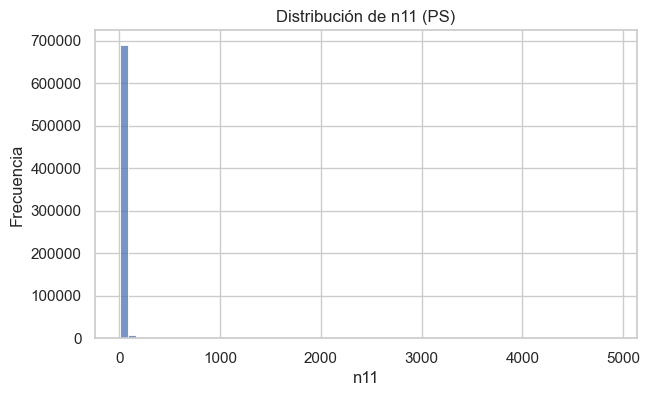

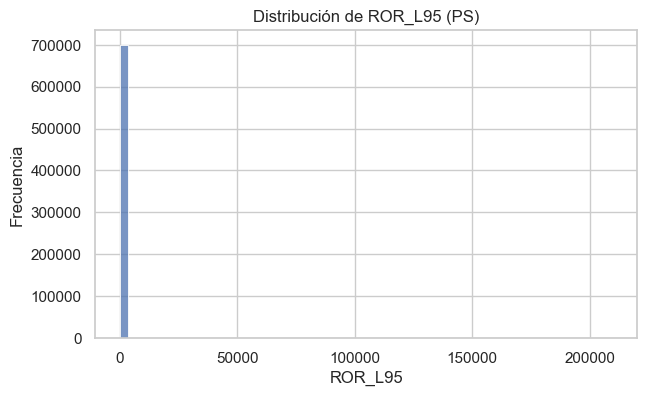

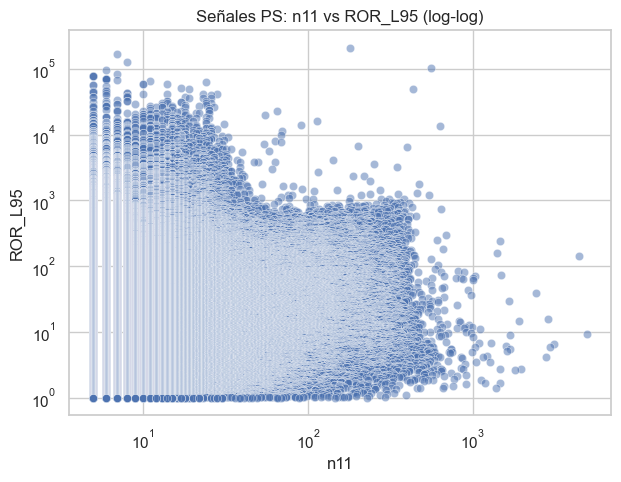

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Hist n11
plt.figure(figsize=(7,4))
sns.histplot(sig_main["n11"], bins=60)
plt.title(f"Distribución de n11 ({MAIN_SCHEME})")
plt.xlabel("n11")
plt.ylabel("Frecuencia")
plt.show()

# Hist ROR_L95 (recortando inf)
tmp_ror = sig_main["ROR_L95"].replace([np.inf, -np.inf], np.nan).dropna()
plt.figure(figsize=(7,4))
sns.histplot(tmp_ror, bins=60)
plt.title(f"Distribución de ROR_L95 ({MAIN_SCHEME})")
plt.xlabel("ROR_L95")
plt.ylabel("Frecuencia")
plt.show()

# Scatter señales
tmp = sig_main[sig_main["signal_ror"]].replace([np.inf, -np.inf], np.nan).dropna(subset=["n11", "ROR_L95"])
plt.figure(figsize=(7,5))
sns.scatterplot(data=tmp, x="n11", y="ROR_L95", alpha=0.5)
plt.xscale("log")
plt.yscale("log")
plt.title(f"Señales {MAIN_SCHEME}: n11 vs ROR_L95 (log-log)")
plt.xlabel("n11")
plt.ylabel("ROR_L95")
plt.show()

Las tres gráficas resumen la estructura de las señales en el esquema **PS** (Primary Suspect). La **distribución de `n11`** muestra una fuerte concentración en valores pequeños, lo que indica que la mayoría de los pares fármaco–reacción aparecen en pocos reportes, mientras que solo una fracción reducida alcanza frecuencias altas. De forma similar, la **distribución de `ROR_L95`** está fuertemente sesgada hacia valores bajos/moderados, con una cola larga de valores extremos; esto es consistente con análisis de desproporcionalidad, donde existen muchas asociaciones débiles o moderadas y pocas señales muy intensas.

La gráfica de dispersión **`n11` vs `ROR_L95` en escala log-log** permite ver esta relación de forma más clara: se observa una gran nube de pares con `n11` bajo y amplia variabilidad en `ROR_L95`, incluyendo outliers con desproporcionalidad muy alta. A medida que aumenta `n11`, la dispersión en `ROR_L95` tiende a concentrarse más, aunque siguen apareciendo señales fuertes con mayor soporte empírico. En conjunto, estas figuras confirman un patrón esperado en farmacovigilancia: **muchas señales raras (algunas extremas) y un subconjunto menor de señales más frecuentes y estables**, lo cual justifica usar tanto rankings por intensidad (p. ej., `ROR_L95`) como métricas de priorización que incorporen frecuencia.

## Conclusiones

En este estudio se implementó un pipeline reproducible para la **detección de señales de farmacovigilancia en FAERS** a partir de los archivos `drugs`, `reactions` y `reports` de cuatro trimestres de 2025. La integración de datos fue exitosa, generando una base consolidada de **11,570,960 pares medicamento–reacción** y **390,140 reportes únicos**, con construcción automática y consistente de `drug_key` a partir de `activesubstancename`.

El análisis se realizó **a nivel reporte (`safetyreportid`)**, lo cual queda explícitamente documentado como alcance metodológico actual, dado que en estos archivos no se dispone de `caseid/version` para aplicar la deduplicación canónica de FAERS por caso. Aun así, el pipeline es útil como análisis exploratorio y de priorización inicial de señales.

La comparación entre los esquemas **PS**, **PS+SS** y **ALL** mostró que el rol del fármaco influye de manera importante en el número de pares evaluados y señales detectadas. En particular, **PS** conserva la mayor parte de los reportes pero restringe el análisis a fármacos sospechosos principales, lo que mejora la interpretabilidad clínica; por ello se adoptó como **análisis principal**, dejando **PS+SS** y **ALL** como análisis de sensibilidad.

Los resultados de desproporcionalidad (ROR, PRR e IC95%) exhiben un patrón esperado en farmacovigilancia: una gran cantidad de pares con soporte bajo (`n11` pequeño), una cola de señales con desproporcionalidad alta y un subconjunto de señales más frecuentes y estables. Los rankings por `ROR_L95` y por `priority_score` resultan complementarios, ya que el primero destaca señales extremas (a veces raras), mientras que el segundo prioriza asociaciones con mejor equilibrio entre intensidad y frecuencia.

La separación de PTs **administrativos/operacionales (`admin-like`)** fue una mejora metodológica relevante: permitió distinguir señales clínicas de términos relacionados con uso del producto, errores de medicación, indicaciones no aprobadas o problemas de calidad/dispositivo, sin eliminarlos del análisis global. Esto mejora la interpretación del análisis principal y abre un canal de análisis complementario útil para farmacovigilancia operativa.

En conjunto, el estudio constituye una **base sólida, documentada y reproducible** para una primera etapa de detección de señales en FAERS. 

In [12]:
OUT_DIR = Path("outputs_faers_report_level")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Guardar base construida desde 3 archivos
pairs.to_parquet(OUT_DIR / "pairs_q1q4_from_drugs_reactions_reports.parquet", index=False)
reports_all.to_parquet(OUT_DIR / "reports_q1q4_concat.parquet", index=False)

# Señales por esquema
if len(sig_ps):
    sig_ps.to_parquet(OUT_DIR / "signals_ps_report_level.parquet", index=False)
if len(sig_ps_ss):
    sig_ps_ss.to_parquet(OUT_DIR / "signals_ps_ss_report_level.parquet", index=False)
sig_all.to_parquet(OUT_DIR / "signals_allroles_report_level.parquet", index=False)

# CSVs de señales positivas (útiles para revisar)
(sig_main[sig_main["signal_ror"]]
 .sort_values(["ROR_L95","n11"], ascending=[False, False])
 .to_csv(OUT_DIR / f"signals_main_{MAIN_SCHEME.lower()}_ror_positive.csv", index=False))

summary_signals.to_csv(OUT_DIR / "summary_signals_role_schemes.csv", index=False)

# Auditoría
audit = pd.DataFrame([{
    "input_pairs_rows": int(len(pairs)),
    "unique_reports": int(pairs["safetyreportid"].nunique()),
    "unique_drugs": int(pairs["drug_key"].nunique()),
    "unique_reactions": int(pairs["reaction_pt"].nunique()),
    "has_caseid_version": False,
    "analysis_level": "safetyreportid",
    "main_scheme": MAIN_SCHEME,
    "main_signal_ror_count": int(sig_main["signal_ror"].sum()),
    "main_signal_prr_count": int(sig_main["signal_prr"].sum()),
    "main_signal_both_count": int(sig_main["signal_both"].sum()),
    "min_n11": MIN_N11,
    "haldane_eps": HALDANE_EPS
}])

audit.to_csv(OUT_DIR / "audit_summary.csv", index=False)

print("Guardado en:", OUT_DIR.resolve())
print("\nArchivos:")
for fp in sorted(OUT_DIR.glob("*")):
    print("-", fp.name)

Guardado en: /Users/jamc/Desktop/FAERS/outputs_faers_report_level

Archivos:
- audit_summary.csv
- pairs_q1q4_from_drugs_reactions_reports.parquet
- reports_q1q4_concat.parquet
- signals_allroles_report_level.parquet
- signals_main_ps_ror_positive.csv
- signals_ps_report_level.parquet
- signals_ps_ss_report_level.parquet
- summary_signals_role_schemes.csv
